## Experiment 1 - Naives RAG System

Jetzt, wo wir einen **Vectorstore** (unsere knowledge base) und synthetischen QA Paare haben, können wir unser naives RAG System über die Fragen laufen, Antworten generieren und diese bewerten lassen. <br>
<br>
• Schritt 1: **Naive RAG pipeline aufsetzen**: Zunächst erstellen wir eine RAG pipeline.<br>
<br>
• Schritt 2: **Antworten generieren**: Fragen werden durch das System geschickt.<br>
<br>
• Schritt 3: **Performance messen**: Die generierten Antworten mit den 3 Metriken der *RAG Triade* bewertet.<br>
<br>

In [1]:
# Imports & keys 

import os
os.chdir("/workspace")

from pathlib import Path
import json
import sys, subprocess, json, asyncio, nest_asyncio
nest_asyncio.apply()

import src.graph.naive_rag as naive_rag_graph
from src.graph.components.configuration import Configuration

from langchain_core.runnables import RunnableConfig

ImportError: cannot import name 'RagStateOutput' from 'src.graph.components.state' (/workspace/src/graph/components/state.py)

### Was macht die Pipeline?

Die erste pipeline ist bewusst so einfach wie möglich aufgebaut: <br>
<br>
Frage → relevante Dokumente werden gesucht → LLM wird mit der Frage + relevanten Dokumente angereichert → LLM generiert Antwort. 
<br>
Die genauen Funktionen (retrival + answer generation) sind `src/graph/naive_rag.py`.


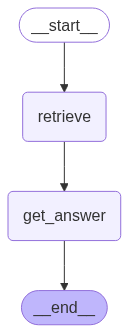

In [26]:
naive_rag_graph.graph

In [4]:
# graph configuration 
cfg = Configuration(
    provider="anthropic", # choose the provider 
    answer_gen_model="claude-3-5-haiku-20241022", # choose the LLM gen model
    temperature=0.5, # set the temperature
    num_answers=3, # number of answers to generate 
    max_tokens=2048, # maximum tokens for the answer generation (keep it short for this test)
)

run_cfg = RunnableConfig(
    configurable=cfg.model_dump()
    )

In [5]:
# run a test question
query = "welche neuen medikamente zur behandlung von psychosen gibt es und wie wirken diese?"

result = naive_rag_graph.graph.invoke(
    {"question": query}, 
    config = run_cfg)

result

{'question': 'welche neuen medikamente zur behandlung von psychosen gibt es und wie wirken diese?',
 'context': [Document(id='a452a6ef-ebd0-4b60-a60d-4503b0d6d10e', metadata={'title': 'FDA lässt neuartiges Medikament zur Behandlung von Schizophrenie zu'}, page_content='„Zudem ist es prinzipiell gut, wenn Behandelnde aus einem breiten Spektrum an guten Medikamenten zur Behandlung der Patienten wählen können. Je nach Person und Krankheitsbild können unterschiedliche Medikamente besser passen. Dies ist seit einigen Jahrzehnten der erste neue Ansatz für ein Schizophrenie-Medikament mit einer offenbar guten Wirksamkeit und anderen Nebenwirkungen. Ob KarXT die bisherigen Medikamente ablösen könnte, wissen wir noch nicht, dafür braucht es die entsprechenden Studien. Ein'),
  Document(id='3cab0201-0ca6-43ee-931b-94de1be567d1', metadata={'title': 'FDA lässt neuartiges Medikament zur Behandlung von Schizophrenie zu'}, page_content='„Obwohl die Schizophrenie eine der sozioökonomisch teuersten Erk

### Antworten für das gesamte Datenset erzeugen

Für jede Frage generieren wir **drei** Antworten. Dadurch minimieren wir Zufallseffekte und machen die spätere Messung robuster.


In [7]:
import pandas as pd
import time
from tqdm import tqdm

# load generated dataset
synth_data = pd.read_csv("data/synthetic_qa_pairs/synthetic_qa_pairs_filtered.csv")

results = []

# iterate through the questions and generate answers
for idx in tqdm(range(len(synth_data)), desc=f"Generating Answer for Question..."):
    question = synth_data.iloc[idx]['input']
    
    try:
        # Run RAG pipeline
        start_time = time.time()
        result = naive_rag_graph.graph.invoke(
            {"question": question}, 
            config=run_cfg
        )
        process_time = time.time() - start_time
        
        # Create base result dictionary
        result_dict = {
            'query_id': idx,
            'question': question,
            'gold_answer': synth_data.iloc[idx]['expected_output'],
            'latency': process_time,
            'context': [ctx.page_content for ctx in result['context']],
            'word_count': sum(len(ctx.page_content.split()) for ctx in result['context']),
        }
        
        # Add individual answers (if we generate more than 1)
        for ans_idx, answer in enumerate(result['answers'], 1):
            result_dict[f'answer_no_{ans_idx}'] = answer
        
        results.append(result_dict)
        
    except Exception as e:
        print(f"Error processing question {idx}: {str(e)}")
        continue

Generating Answer for Question...: 100%|██████████| 50/50 [17:31<00:00, 21.04s/it]


In [8]:
# save final results
output_path = Path('results/simple_rag_res.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResults saved to {output_path}")


Results saved to results/simple_rag_res.json


In [38]:
# load final results
results = json.load(open("results/simple_rag_res.json", encoding="utf-8"))

In [22]:
from random import randrange

results[randrange(49)]

{'query_id': 43,
 'question': 'Wie wirken sich die steigenden Strompreise auf das Verbraucherverhalten aus, besonders wenn die Energieerzeugung niedrig ist?',
 'gold_answer': 'Die steigenden Strompreise beeinflussen das Verbraucherverhalten nur geringfügig, da die hohen Börsenpreise für die meisten Haushalte nicht signifikant ins Gewicht fallen. In Phasen niedriger Energieerzeugung, wie während der Dunkelflaute, bleibt die Versorgungssicherheit dank ausreichend steuerbarer Kraftwerke gewährleistet. Daher ist vorsichtiger Umgang mit Eingriffen in den Strommarkt empfohlen, um unerwünschte Nebenwirkungen zu vermeiden.',
 'latency': 18.4108989238739,
 'context': ['Einfluss hoher Preise an der Strombörse in Schwachwindzeiten auf Verbraucherpreis:',
  'Einfluss hoher Preise an der Strombörse in Schwachwindzeiten auf Verbraucherpreis:',
  '„Für viele Gewerbe- und Industriekunden spielen die schwankenden Großhandelspreise eine größere Rolle als für Haushaltskunden. Da gibt es große Unterschied

### Bewertung der generierten Antworten
<br>
Unsere ´results´ beinhalten pro Eintrag:
<br>
• die synthetische Frage  <br>
• die vom Retriever gefundenen Kontexte <br>
• 3 generierte Antworten <br>
<br>
Im letzten Schritt bewerten wir jede generierte Antwort mit der **RAG Triade**: <br>
<br>
• **Contextual Relevancy** – Wie gut passt der Kontext zur Frage? <br>
<br>
• **Answer Relevancy** – Wie gut passt die Antwort zur Frage? <br>
<br>
• **Faithfulness** – Nutzt die Antwort nur Fakten aus dem Kontext? <br>
<br>

> Bei echten Projekten lohnt es sich, zusätzlich eigene Metriken (z. B. Quellenvielfalt, Aktualität, Formulierung, Länge usw.) zu definieren und zu automatisieren  
> Die RAG Triade ist ein guter Startpunkt für ein Projekt, deckt aber meistens nicht alle Anforderungen und spezielle use-cases ab.

In [23]:
from src.utils.evals import rate_dataset 

# evaluation
rated_results = asyncio.run(rate_dataset(results, model="gpt-4o-mini", max_concurrency=5))

Scoring answers: 100%|██████████| 50/50 [08:27<00:00, 10.16s/it]


In [24]:
# save evaluated results
output_path = Path('results/simple_rag_res_rated.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"\nResults saved to {output_path}")


Results saved to results/simple_rag_res_rated.json
